In [1]:
!pip install -q torch torchvision torchaudio timm scikit-learn seaborn matplotlib pandas GPUtil

  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 4.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 79.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 55.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 43.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 5.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 12.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 7.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 5.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 106.8 MB/s eta 0:00:00


In [2]:
!pip install --upgrade typing-extensions

In [1]:
# Imports
import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
import torchvision
from torchvision import datasets, models, transforms
import timm # PyTorch Image Models library
import numpy as np
import matplotlib.pyplot as plt
import time
import os
import copy
from sklearn.metrics import classification_report, confusion_matrix, f1_score, precision_score, recall_score
import seaborn as sns
import pandas as pd
from GPUtil import showUtilization as gpu_usage
# --- AMP Imports ---
from torch.cuda.amp import GradScaler, autocast
# -------------------

# Check GPU availability and set device
if torch.cuda.is_available():
    device = torch.device("cuda")
    print(f'Using GPU: {torch.cuda.get_device_name(0)}')
    gpu_usage()
else:
    device = torch.device("cpu")
    print('GPU not available, using CPU.')
    print("WARNING: Training will be very slow without a GPU.")


Using GPU: Tesla T4
| ID | GPU | MEM |
------------------
|  0 |  0% |  0% |


In [2]:
config = {
    "data_dir": '/content/PlantVillage/PlantVillage',
    # Transformers often work best with 224x224
    "image_size": 224,
    "batch_size": 32, # Adjust based on Colab GPU memory (T4/P100 can handle 64)
    "num_classes": 15, # PlantVillage has 38 classes
    "learning_rate": 3e-5, # Lower LR often better for fine-tuning ensembles
    "weight_decay": 1e-4,
    "num_epochs": 20, # Start with fewer epochs, increase if needed
    "seed": 42,
    "checkpoint_path": "plant_ensemble_pytorch.pth",
    # Define base model names (compatible with torchvision and timm)
    "base_models": {
        "vgg": "vgg16",
        "resnet": "resnet50",
        "vit": "vit_base_patch16_224", # ViT base model, 224px input
        "swin": "swin_tiny_patch4_window7_224" # Swin tiny model, 224px input
    }
}

# Set seed for reproducibility
torch.manual_seed(config['seed'])
np.random.seed(config['seed'])
if torch.cuda.is_available():
    torch.cuda.manual_seed_all(config['seed'])


In [10]:
import kagglehub

# Download latest version
path = kagglehub.dataset_download("arjuntejaswi/plant-village")

print("Path to dataset files:", path)

Path to dataset files: /kaggle/input/plant-village


In [11]:
!mkdir "PlantVillage"
!cp -r "/kaggle/input/plant-village/PlantVillage" "/content/PlantVillage"
#!cp -r "/kaggle/input/plant-village/PlantVillage/Pepper__bell___healthy/" "/content/PlantVillage"

mkdir: cannot create directory ‘PlantVillage’: File exists


In [3]:
# Define transformations with ImageNet normalization
imagenet_mean = [0.485, 0.456, 0.406]
imagenet_std = [0.229, 0.224, 0.225]

data_transforms = {
    'train': transforms.Compose([
        transforms.RandomResizedCrop(config['image_size'], scale=(0.8, 1.0)), # Crop less aggressively
        transforms.RandomHorizontalFlip(),
        transforms.RandomRotation(30), # Increased rotation
        transforms.ColorJitter(brightness=0.3, contrast=0.3, saturation=0.3, hue=0.1), # Stronger jitter
        transforms.ToTensor(),
        transforms.Normalize(imagenet_mean, imagenet_std)
    ]),
    'val': transforms.Compose([
        transforms.Resize(config['image_size'] + 32), # 256 for 224 input size
        transforms.CenterCrop(config['image_size']),
        transforms.ToTensor(),
        transforms.Normalize(imagenet_mean, imagenet_std)
    ]),
}

# Create datasets using ImageFolder & manual split (80/20)
full_dataset = datasets.ImageFolder(config['data_dir'], transform=data_transforms['train']) # Use train transforms for subset creation
val_dataset_temp = datasets.ImageFolder(config['data_dir'], transform=data_transforms['val']) # Use val transforms

# Define splits (e.g., 70% train, 20% val, 10% test)
num_total = len(full_dataset)
num_train = int(0.7 * num_total)
num_val = int(0.2 * num_total)
num_test = num_total - num_train - num_val  # ensures all samples are used

indices = list(range(num_total))
np.random.shuffle(indices)

train_indices = indices[:num_train]
val_indices = indices[num_train:num_train + num_val]
test_indices = indices[num_train + num_val:]

# Use train transforms for train, val transforms for val and test
image_datasets = {
    'train': torch.utils.data.Subset(full_dataset, train_indices),
    'val': torch.utils.data.Subset(val_dataset_temp, val_indices),
    'test': torch.utils.data.Subset(val_dataset_temp, test_indices)
}


In [4]:
print(f"Dataset sizes: Train={len(image_datasets['train'])}, Val={len(image_datasets['val'])}, Test={len(image_datasets['test'])}")
print(len(full_dataset.classes))

Dataset sizes: Train=14446, Val=4127, Test=2065
15


In [5]:
# Create dataloaders

dataloaders = {
    x: torch.utils.data.DataLoader(
        image_datasets[x],
        batch_size=config['batch_size'],
        shuffle=(x == 'train'),
        num_workers=2,
        pin_memory=True
    )
    for x in ['train', 'val', 'test']
}
dataset_sizes = {x: len(image_datasets[x]) for x in ['train', 'val', 'test']}
class_names = full_dataset.classes

print(f"Dataset sizes: Train={dataset_sizes['train']}, Val={dataset_sizes['val']}, Test={dataset_sizes['test']}")
print(f"Number of classes: {len(class_names)}")



Dataset sizes: Train=14446, Val=4127, Test=2065
Number of classes: 15


In [6]:

# ## 4. Model Architecture: PyTorch Ensemble with Robust Fusion Head
# Corrected VGG Feature Extraction
# %%
class PlantEnsembleRobust(nn.Module):
    def __init__(self, model_names, num_classes, pretrained=True):
        super().__init__()
        self.num_classes = num_classes
        self.feature_extractors = nn.ModuleDict()
        feature_dim = 0

        # --- Load Base Models ---
        # VGG16
        vgg = models.vgg16(weights='VGG16_Weights.IMAGENET1K_V1' if pretrained else None)
        vgg.classifier = nn.Identity() # Remove classifier part
        self.feature_extractors['vgg'] = vgg
        # We need a separate global pool layer for VGG's feature output
        self.vgg_global_pool = nn.AdaptiveAvgPool2d((1, 1))
        feature_dim += 512 # VGG output *after correct global pooling* is 512

        # ResNet50
        resnet = models.resnet50(weights='ResNet50_Weights.IMAGENET1K_V2' if pretrained else None)
        resnet.fc = nn.Identity() # Remove final FC layer
        self.feature_extractors['resnet'] = resnet
        feature_dim += 2048

        # ViT using timm
        vit = timm.create_model(model_names['vit'], pretrained=pretrained, num_classes=0, global_pool='avg')
        self.feature_extractors['vit'] = vit
        feature_dim += vit.num_features # Should be 768

        # Swin Transformer using timm
        swin = timm.create_model(model_names['swin'], pretrained=pretrained, num_classes=0, global_pool='avg')
        self.feature_extractors['swin'] = swin
        feature_dim += swin.num_features # Should be 768

        # --- Verify Feature Dim Calculation ---
        # Expected: 512 + 2048 + 768 + 768 = 4096
        print(f"Expected total feature dimension before fusion: {feature_dim}")
        # --------------------------------------

        # --- Robust Fusion Head (Initialized with the *expected* feature_dim) ---
        self.fusion_head = nn.Sequential(
            nn.BatchNorm1d(feature_dim), # Expects 4096 features
            nn.Linear(feature_dim, 1024),
            nn.ReLU(inplace=True),
            nn.Dropout(0.5),
            nn.BatchNorm1d(1024), # Expects 1024 features
            nn.Linear(1024, 512),
            nn.ReLU(inplace=True),
            nn.Dropout(0.5),
            nn.Linear(512, num_classes)
        )

    def forward(self, x):
        features = []
        # Extract features

        # --- CORRECTED VGG Feature Extraction ---
        vgg_feat_map = self.feature_extractors['vgg'].features(x) # Output: [N, 512, H', W']
        vgg_feat_pooled = self.vgg_global_pool(vgg_feat_map) # Output: [N, 512, 1, 1]
        vgg_feat_flat = torch.flatten(vgg_feat_pooled, 1) # Output: [N, 512]
        features.append(vgg_feat_flat)
        # ---------------------------------------

        resnet_feat = self.feature_extractors['resnet'](x) # Output: [N, 2048]
        features.append(resnet_feat)

        vit_feat = self.feature_extractors['vit'](x) # Output: [N, 768]
        features.append(vit_feat)

        swin_feat = self.feature_extractors['swin'](x) # Output: [N, 768]
        features.append(swin_feat)

        # Concatenate features - Should now be [N, 4096]
        combined_features = torch.cat(features, dim=1)

        # Pass through robust fusion head
        output = self.fusion_head(combined_features)
        return output

# --- Rest of the cell remains the same ---
# Instantiate the model
ensemble_model = PlantEnsembleRobust(config['base_models'], config['num_classes'])
ensemble_model = ensemble_model.to(device)

total_params = sum(p.numel() for p in ensemble_model.parameters() if p.requires_grad)
print(f"Total trainable parameters: {total_params / 1_000_000:.2f} M")
# Optional: Print model summary again after fix
print(ensemble_model)
# --------------------------------------------


/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


Expected total feature dimension before fusion: 4096
Total trainable parameters: 156.28 M
PlantEnsembleRobust(
  (feature_extractors): ModuleDict(
    (vgg): VGG(
      (features): Sequential(
        (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (1): ReLU(inplace=True)
        (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (3): ReLU(inplace=True)
        (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
        (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (6): ReLU(inplace=True)
        (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (8): ReLU(inplace=True)
        (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
        (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (11): ReLU(inplace=True)
        (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padd

In [16]:
!pip install torchinfo

In [7]:
from torchinfo import summary

# Assume input image size is (3, 224, 224) like ImageNet models
summary(ensemble_model, input_size=(1, 3, 224, 224), depth=3, col_names=["input_size", "output_size", "num_params"])


Layer (type:depth-idx)                                       Input Shape               Output Shape              Param #
PlantEnsembleRobust                                          [1, 3, 224, 224]          [1, 15]                   --
├─ModuleDict: 1-3                                            --                        --                        (recursive)
│    └─VGG: 2-1                                              --                        --                        --
│    │    └─Sequential: 3-1                                  [1, 3, 224, 224]          [1, 512, 7, 7]            14,714,688
├─AdaptiveAvgPool2d: 1-2                                     [1, 512, 7, 7]            [1, 512, 1, 1]            --
├─ModuleDict: 1-3                                            --                        --                        (recursive)
│    └─ResNet: 2-2                                           [1, 3, 224, 224]          [1, 2048]                 --
│    │    └─Conv2d: 3-2                  

In [19]:
!pip install torchviz

In [21]:
from torchviz import make_dot

# Pass a dummy input through your model
dummy_input = torch.randn(2, 3, 224, 224).to(device)
output = ensemble_model(dummy_input)

# Create the computation graph
dot = make_dot(output, params=dict(ensemble_model.named_parameters()))

# Save the graph
dot.format = 'png'
dot.directory = 'your_save_folder' # You can leave it default
dot.view('ensemble_model_graph')


dot: graph is too large for cairo-renderer bitmaps. Scaling by 0.599195 to fit


'your_save_folder/ensemble_model_graph.png'

In [23]:
!pip install hiddenlayer

In [29]:
!pip install onnx


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 16.0/16.0 MB 20.6 MB/s eta 0:00:00


In [30]:
dummy_input = torch.randn(2, 3, 224, 224).to(device)

# Export with correct opset
torch.onnx.export(
    ensemble_model,
    dummy_input,
    "ensemble_model.onnx",
    input_names=["input"],
    output_names=["output"],
    opset_version=17,
    dynamic_axes={
        'input': {0: 'batch_size'},
        'output': {0: 'batch_size'}
    }
)

print("Model successfully exported to ONNX!")


Model successfully exported to ONNX!


In [8]:
# Instantiate the model
ensemble_model = PlantEnsembleRobust(config['base_models'], config['num_classes'])
ensemble_model = ensemble_model.to(device)

total_params = sum(p.numel() for p in ensemble_model.parameters() if p.requires_grad)
print(f"Total trainable parameters: {total_params / 1_000_000:.2f} M")



# Includes loss, optimizer, scheduler, and AMP GradScaler.

criterion = nn.CrossEntropyLoss()

optimizer = optim.AdamW(ensemble_model.parameters(),
                        lr=config['learning_rate'],
                        weight_decay=config['weight_decay']) # L2 regularization via weight decay

scheduler = lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.2, patience=4, verbose=True) # Increased patience

# --- AMP GradScaler ---
scaler = GradScaler()
# --------------------

# Early stopping parameters
early_stopping_patience = 7 # Increased patience slightly
early_stopping_counter = 0
best_val_f1 = 0.0 # Monitor F1 score for saving best model


Expected total feature dimension before fusion: 4096
Total trainable parameters: 156.28 M


/usr/local/lib/python3.11/dist-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(
<ipython-input-8-206b6f36c09f>:21: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = GradScaler()


In [9]:
def train_one_epoch(model, criterion, optimizer, dataloader, device, scaler): # Added scaler
    model.train()
    running_loss = 0.0
    running_corrects = 0
    total_samples = 0

    # Wrap dataloader with tqdm for progress bar (optional)
    from tqdm.notebook import tqdm
    progress_bar = tqdm(dataloader, desc="Training", leave=False)
    for inputs, labels in progress_bar:

        inputs = inputs.to(device, non_blocking=True) # Use non_blocking with pin_memory=True
        labels = labels.to(device, non_blocking=True)
        optimizer.zero_grad()

        # --- Mixed Precision Forward ---
        with autocast():
            outputs = model(inputs)
            loss = criterion(outputs, labels)
        # -----------------------------

        # --- Scaled Backward & Optimizer Step ---
        scaler.scale(loss).backward()
        scaler.step(optimizer)
        scaler.update()
        # ------------------------------------

        # Statistics
        _, preds = torch.max(outputs, 1)
        running_loss += loss.item() * inputs.size(0)
        running_corrects += torch.sum(preds == labels.data)
        total_samples += inputs.size(0)

        # Optional: Update tqdm progress bar description
        progress_bar.set_postfix(loss=loss.item())

    epoch_loss = running_loss / total_samples
    epoch_acc = running_corrects.double() / total_samples

    print(f'Train Loss: {epoch_loss:.4f} Acc: {epoch_acc:.4f}')
    return epoch_loss, epoch_acc


In [10]:
def validate(model, criterion, dataloader, device):
    model.eval()
    running_loss = 0.0
    running_corrects = 0
    all_preds = []
    all_labels = []
    total_samples = 0

    with torch.no_grad():
        from tqdm.notebook import tqdm
        progress_bar = tqdm(dataloader, desc="Validation", leave=False)
        for inputs, labels in progress_bar:
        # Use this if not using tqdm
            inputs = inputs.to(device, non_blocking=True)
            labels = labels.to(device, non_blocking=True)

            # --- Mixed Precision Forward (for consistency) ---
            with autocast():
                outputs = model(inputs)
                loss = criterion(outputs, labels)
            # ---------------------------------------------

            _, preds = torch.max(outputs, 1)
            running_loss += loss.item() * inputs.size(0)
            running_corrects += torch.sum(preds == labels.data)
            total_samples += inputs.size(0)

            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    epoch_loss = running_loss / total_samples
    epoch_acc = running_corrects.double() / total_samples
    # Calculate metrics using sklearn (safer for multi-class, handles zero division)
    epoch_f1 = f1_score(all_labels, all_preds, average='macro', zero_division=0)
    epoch_precision = precision_score(all_labels, all_preds, average='macro', zero_division=0)
    epoch_recall = recall_score(all_labels, all_preds, average='macro', zero_division=0)

    print(f'Val Loss: {epoch_loss:.4f} Acc: {epoch_acc:.4f} F1: {epoch_f1:.4f}')
    return epoch_loss, epoch_acc, epoch_f1, epoch_precision, epoch_recall, all_labels, all_preds


In [11]:
history = {
    'train_loss': [], 'train_acc': [],
    'val_loss': [], 'val_acc': [], 'val_f1': [],
    'val_precision': [], 'val_recall': []
}
best_model_wts = copy.deepcopy(ensemble_model.state_dict())
# Use best_val_f1 for saving the model
best_acc = 0.0

print("Starting Training with AMP...")
start_time = time.time()

for epoch in range(config['num_epochs']):
    print(f'\nEpoch {epoch+1}/{config["num_epochs"]}')
    print('-' * 10)

    # Train phase
    train_loss, train_acc = train_one_epoch(ensemble_model, criterion, optimizer, dataloaders['train'], device, scaler) # Pass scaler
    history['train_loss'].append(train_loss)
    history['train_acc'].append(train_acc.item())

    # Validation phase
    val_loss, val_acc, val_f1, val_precision, val_recall, _, _ = validate(ensemble_model, criterion, dataloaders['val'], device)
    history['val_loss'].append(val_loss)
    history['val_acc'].append(val_acc.item())
    history['val_f1'].append(val_f1)
    history['val_precision'].append(val_precision)
    history['val_recall'].append(val_recall)

    # Update learning rate scheduler based on validation loss
    scheduler.step(val_loss)

    # Checkpoint saving: save if validation F1 improves
    if val_f1 > best_val_f1:
        print(f"Validation F1 improved ({best_val_f1:.4f} --> {val_f1:.4f}). Saving model...")
        best_val_f1 = val_f1
        # best_acc = val_acc
        best_model_wts = copy.deepcopy(ensemble_model.state_dict())
        torch.save(ensemble_model.state_dict(), config['checkpoint_path'])
        early_stopping_counter = 0 # Reset counter
    else:
         early_stopping_counter += 1
         print(f"Validation F1 did not improve. Counter: {early_stopping_counter}/{early_stopping_patience}")

    # Early stopping check
    if early_stopping_counter >= early_stopping_patience:
        print(f"Early stopping triggered after {epoch + 1} epochs.")
        break

    print(f"Current Learning Rate: {optimizer.param_groups[0]['lr']:.6f}")
    gpu_usage() # Show GPU usage each epoch
    torch.cuda.empty_cache() # Clear cache periodically (might help slightly)


Starting Training with AMP...

Epoch 1/20
----------


Training:   0%|          | 0/452 [00:00<?, ?it/s]

<ipython-input-9-143330e95f5d>:17: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():


Train Loss: 1.0082 Acc: 0.7789


Validation:   0%|          | 0/129 [00:00<?, ?it/s]

<ipython-input-10-776727209af4>:18: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():


Val Loss: 0.1827 Acc: 0.9629 F1: 0.8917
Validation F1 improved (0.0000 --> 0.8917). Saving model...
Current Learning Rate: 0.000030
| ID | GPU | MEM |
------------------
|  0 |  2% | 73% |

Epoch 2/20
----------


Training:   0%|          | 0/452 [00:00<?, ?it/s]

<ipython-input-9-143330e95f5d>:17: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():


Train Loss: 0.1688 Acc: 0.9697


Validation:   0%|          | 0/129 [00:00<?, ?it/s]

<ipython-input-10-776727209af4>:18: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():


Val Loss: 0.0723 Acc: 0.9813 F1: 0.9741
Validation F1 improved (0.8917 --> 0.9741). Saving model...
Current Learning Rate: 0.000030
| ID | GPU | MEM |
------------------
|  0 |  2% | 77% |

Epoch 3/20
----------


Training:   0%|          | 0/452 [00:00<?, ?it/s]

<ipython-input-9-143330e95f5d>:17: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():


Train Loss: 0.0882 Acc: 0.9796


Validation:   0%|          | 0/129 [00:00<?, ?it/s]

<ipython-input-10-776727209af4>:18: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():


Val Loss: 0.0818 Acc: 0.9736 F1: 0.9722
Validation F1 did not improve. Counter: 1/7
Current Learning Rate: 0.000030
| ID | GPU | MEM |
------------------
|  0 | 68% | 78% |

Epoch 4/20
----------


Training:   0%|          | 0/452 [00:00<?, ?it/s]

<ipython-input-9-143330e95f5d>:17: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():


Train Loss: 0.0638 Acc: 0.9853


Validation:   0%|          | 0/129 [00:00<?, ?it/s]

<ipython-input-10-776727209af4>:18: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():


Val Loss: 0.0717 Acc: 0.9823 F1: 0.9794
Validation F1 improved (0.9741 --> 0.9794). Saving model...
Current Learning Rate: 0.000030
| ID | GPU | MEM |
------------------
|  0 |  5% | 78% |

Epoch 5/20
----------


Training:   0%|          | 0/452 [00:00<?, ?it/s]

<ipython-input-9-143330e95f5d>:17: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():


Train Loss: 0.0510 Acc: 0.9880


Validation:   0%|          | 0/129 [00:00<?, ?it/s]

<ipython-input-10-776727209af4>:18: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():


Val Loss: 0.0403 Acc: 0.9872 F1: 0.9826
Validation F1 improved (0.9794 --> 0.9826). Saving model...
Current Learning Rate: 0.000030
| ID | GPU | MEM |
------------------
|  0 |  3% | 79% |

Epoch 6/20
----------


Training:   0%|          | 0/452 [00:00<?, ?it/s]

<ipython-input-9-143330e95f5d>:17: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():


Train Loss: 0.0400 Acc: 0.9898


Validation:   0%|          | 0/129 [00:00<?, ?it/s]

<ipython-input-10-776727209af4>:18: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():


Val Loss: 0.0811 Acc: 0.9738 F1: 0.9735
Validation F1 did not improve. Counter: 1/7
Current Learning Rate: 0.000030
| ID | GPU  | MEM |
-------------------
|  0 | 100% | 79% |

Epoch 7/20
----------


Training:   0%|          | 0/452 [00:00<?, ?it/s]

<ipython-input-9-143330e95f5d>:17: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():


Train Loss: 0.0337 Acc: 0.9910


Validation:   0%|          | 0/129 [00:00<?, ?it/s]

<ipython-input-10-776727209af4>:18: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():


Val Loss: 0.0190 Acc: 0.9930 F1: 0.9926
Validation F1 improved (0.9826 --> 0.9926). Saving model...
Current Learning Rate: 0.000030
| ID | GPU | MEM |
------------------
|  0 |  2% | 79% |

Epoch 8/20
----------


Training:   0%|          | 0/452 [00:00<?, ?it/s]

<ipython-input-9-143330e95f5d>:17: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():


Train Loss: 0.0327 Acc: 0.9917


Validation:   0%|          | 0/129 [00:00<?, ?it/s]

<ipython-input-10-776727209af4>:18: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():


Val Loss: 0.0227 Acc: 0.9927 F1: 0.9902
Validation F1 did not improve. Counter: 1/7
Current Learning Rate: 0.000030
| ID | GPU  | MEM |
-------------------
|  0 | 100% | 79% |

Epoch 9/20
----------


Training:   0%|          | 0/452 [00:00<?, ?it/s]

<ipython-input-9-143330e95f5d>:17: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():


Train Loss: 0.0364 Acc: 0.9895


Validation:   0%|          | 0/129 [00:00<?, ?it/s]

<ipython-input-10-776727209af4>:18: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():


Val Loss: 0.0301 Acc: 0.9898 F1: 0.9834
Validation F1 did not improve. Counter: 2/7
Current Learning Rate: 0.000030
| ID | GPU | MEM |
------------------
|  0 | 69% | 76% |

Epoch 10/20
----------


Training:   0%|          | 0/452 [00:00<?, ?it/s]

<ipython-input-9-143330e95f5d>:17: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():


Train Loss: 0.0266 Acc: 0.9924


Validation:   0%|          | 0/129 [00:00<?, ?it/s]

<ipython-input-10-776727209af4>:18: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():


Val Loss: 0.0123 Acc: 0.9964 F1: 0.9958
Validation F1 improved (0.9926 --> 0.9958). Saving model...
Current Learning Rate: 0.000030
| ID | GPU | MEM |
------------------
|  0 |  2% | 76% |

Epoch 11/20
----------


Training:   0%|          | 0/452 [00:00<?, ?it/s]

<ipython-input-9-143330e95f5d>:17: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():


Train Loss: 0.0248 Acc: 0.9928


Validation:   0%|          | 0/129 [00:00<?, ?it/s]

<ipython-input-10-776727209af4>:18: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():


Val Loss: 0.0607 Acc: 0.9850 F1: 0.9819
Validation F1 did not improve. Counter: 1/7
Current Learning Rate: 0.000030
| ID | GPU | MEM |
------------------
|  0 | 49% | 79% |

Epoch 12/20
----------


Training:   0%|          | 0/452 [00:00<?, ?it/s]

<ipython-input-9-143330e95f5d>:17: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():


Train Loss: 0.0270 Acc: 0.9920


Validation:   0%|          | 0/129 [00:00<?, ?it/s]

<ipython-input-10-776727209af4>:18: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():


Val Loss: 0.0235 Acc: 0.9915 F1: 0.9897
Validation F1 did not improve. Counter: 2/7
Current Learning Rate: 0.000030
| ID | GPU | MEM |
------------------
|  0 | 90% | 79% |

Epoch 13/20
----------


Training:   0%|          | 0/452 [00:00<?, ?it/s]

<ipython-input-9-143330e95f5d>:17: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():


Train Loss: 0.0274 Acc: 0.9927


Validation:   0%|          | 0/129 [00:00<?, ?it/s]

<ipython-input-10-776727209af4>:18: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():


Val Loss: 0.0176 Acc: 0.9937 F1: 0.9940
Validation F1 did not improve. Counter: 3/7
Current Learning Rate: 0.000030
| ID | GPU | MEM |
------------------
|  0 | 99% | 79% |

Epoch 14/20
----------


Training:   0%|          | 0/452 [00:00<?, ?it/s]

<ipython-input-9-143330e95f5d>:17: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():


Train Loss: 0.0255 Acc: 0.9927


Validation:   0%|          | 0/129 [00:00<?, ?it/s]

<ipython-input-10-776727209af4>:18: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():


Val Loss: 0.0230 Acc: 0.9935 F1: 0.9920
Validation F1 did not improve. Counter: 4/7
Current Learning Rate: 0.000030
| ID | GPU | MEM |
------------------
|  0 | 81% | 79% |

Epoch 15/20
----------


Training:   0%|          | 0/452 [00:00<?, ?it/s]

<ipython-input-9-143330e95f5d>:17: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():


Train Loss: 0.0169 Acc: 0.9954


Validation:   0%|          | 0/129 [00:00<?, ?it/s]

<ipython-input-10-776727209af4>:18: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():


Val Loss: 0.0176 Acc: 0.9949 F1: 0.9943
Validation F1 did not improve. Counter: 5/7
Current Learning Rate: 0.000006
| ID | GPU | MEM |
------------------
|  0 | 75% | 79% |

Epoch 16/20
----------


Training:   0%|          | 0/452 [00:00<?, ?it/s]

<ipython-input-9-143330e95f5d>:17: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():


Train Loss: 0.0073 Acc: 0.9979


Validation:   0%|          | 0/129 [00:00<?, ?it/s]

<ipython-input-10-776727209af4>:18: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():


Val Loss: 0.0079 Acc: 0.9973 F1: 0.9964
Validation F1 improved (0.9958 --> 0.9964). Saving model...
Current Learning Rate: 0.000006
| ID | GPU | MEM |
------------------
|  0 |  2% | 79% |

Epoch 17/20
----------


Training:   0%|          | 0/452 [00:00<?, ?it/s]

<ipython-input-9-143330e95f5d>:17: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():


Train Loss: 0.0051 Acc: 0.9990


Validation:   0%|          | 0/129 [00:00<?, ?it/s]

<ipython-input-10-776727209af4>:18: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():


Val Loss: 0.0065 Acc: 0.9981 F1: 0.9964
Validation F1 did not improve. Counter: 1/7
Current Learning Rate: 0.000006
| ID | GPU | MEM |
------------------
|  0 | 99% | 79% |

Epoch 18/20
----------


Training:   0%|          | 0/452 [00:00<?, ?it/s]

<ipython-input-9-143330e95f5d>:17: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():


Train Loss: 0.0030 Acc: 0.9994


Validation:   0%|          | 0/129 [00:00<?, ?it/s]

<ipython-input-10-776727209af4>:18: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():


Val Loss: 0.0043 Acc: 0.9988 F1: 0.9980
Validation F1 improved (0.9964 --> 0.9980). Saving model...
Current Learning Rate: 0.000006
| ID | GPU | MEM |
------------------
|  0 |  2% | 79% |

Epoch 19/20
----------


Training:   0%|          | 0/452 [00:00<?, ?it/s]

<ipython-input-9-143330e95f5d>:17: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():


KeyboardInterrupt: 

In [12]:
# Calculate training time
time_elapsed = time.time() - start_time
print(f'\nTraining complete in {time_elapsed // 60:.0f}m {time_elapsed % 60:.0f}s')
print(f'Best Validation F1-Score: {best_val_f1:.4f}')
# print(f'Corresponding Validation Accuracy: {best_acc:.4f}') # If tracking best_acc

# Load best model weights for final evaluation
print(f"Loading best model weights from {config['checkpoint_path']}")
try:
    ensemble_model.load_state_dict(torch.load(config['checkpoint_path']))
except Exception as e:
    print(f"Error loading weights: {e}. Using last model state.")
    # Optionally load best_model_wts if saved in memory
    # ensemble_model.load_state_dict(best_model_wts)



Training complete in 117m 28s
Best Validation F1-Score: 0.9980
Loading best model weights from plant_ensemble_pytorch.pth


In [13]:
print("\nEvaluating best model on validation set...")
# Run validation again with the best loaded model
final_val_loss, final_val_acc, final_val_f1, final_val_precision, final_val_recall, all_labels, all_preds = validate(ensemble_model, criterion, dataloaders['val'], device)

print("\n--- Final Validation Metrics (Best Model) ---")
print(f"Accuracy:  {final_val_acc:.4f}")
print(f"F1-Score (Macro): {final_val_f1:.4f}")
print(f"Precision (Macro): {final_val_precision:.4f}")
print(f"Recall (Macro):    {final_val_recall:.4f}")
print("-" * 40)


Evaluating best model on validation set...


Validation:   0%|          | 0/129 [00:00<?, ?it/s]

<ipython-input-10-776727209af4>:18: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():


Val Loss: 0.0043 Acc: 0.9988 F1: 0.9980

--- Final Validation Metrics (Best Model) ---
Accuracy:  0.9988
F1-Score (Macro): 0.9980
Precision (Macro): 0.9988
Recall (Macro):    0.9971
----------------------------------------


In [14]:
print('\nClassification Report (Best Model):')
try:
    report = classification_report(all_labels, all_preds, target_names=class_names, digits=4, zero_division=0)
    print(report)
except ValueError as e:
    print(f"Could not generate report with class names: {e}")
    report = classification_report(all_labels, all_preds, digits=4, zero_division=0)
    print(report)


Classification Report (Best Model):
                                             precision    recall  f1-score   support

              Pepper__bell___Bacterial_spot     1.0000    1.0000    1.0000       204
                     Pepper__bell___healthy     0.9968    1.0000    0.9984       312
                      Potato___Early_blight     1.0000    1.0000    1.0000       184
                       Potato___Late_blight     1.0000    0.9948    0.9974       192
                           Potato___healthy     1.0000    0.9722    0.9859        36
                      Tomato_Bacterial_spot     1.0000    0.9977    0.9988       428
                        Tomato_Early_blight     1.0000    0.9946    0.9973       186
                         Tomato_Late_blight     0.9971    1.0000    0.9986       348
                           Tomato_Leaf_Mold     1.0000    1.0000    1.0000       190
                  Tomato_Septoria_leaf_spot     1.0000    1.0000    1.0000       366
Tomato_Spider_mites_Two_spo


Confusion Matrix (Best Model):


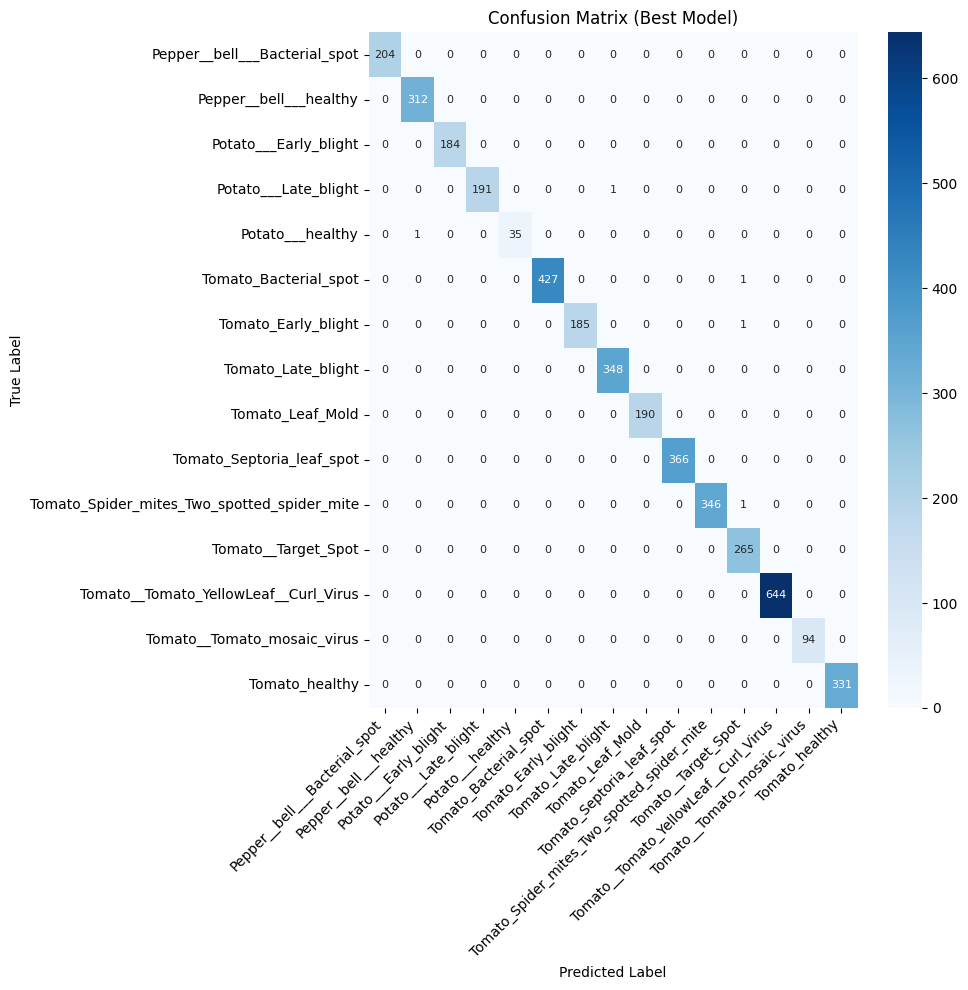

In [15]:
# Confusion Matrix
print('\nConfusion Matrix (Best Model):')
cm = confusion_matrix(all_labels, all_preds)
plt.figure(figsize=(10, 10)) # Adjusted size slightly
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names, annot_kws={"size": 8}) # Smaller font size for annotations
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix (Best Model)')
plt.xticks(rotation=45, ha='right') # Rotate x-axis labels if needed
plt.yticks(rotation=0)
plt.tight_layout() # Adjust layout
plt.savefig("Confusion_matrix_ensemble.png", dpi = 300)
plt.show()

In [16]:
def plot_history(history):
    epochs = range(1, len(history['train_loss']) + 1)

    plt.figure(figsize=(20, 6)) # Wider figure

    # Plot Loss
    plt.subplot(1, 3, 1)
    plt.plot(epochs, history['train_loss'], 'bo-', label='Training Loss')
    plt.plot(epochs, history['val_loss'], 'ro-', label='Validation Loss')
    plt.title('Training and Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.grid(axis='y', linestyle='--')

    # Plot Accuracy
    plt.subplot(1, 3, 2)
    plt.plot(epochs, history['train_acc'], 'bo-', label='Training Accuracy')
    plt.plot(epochs, history['val_acc'], 'ro-', label='Validation Accuracy')
    plt.title('Training and Validation Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.grid(axis='y', linestyle='--')


    # Plot F1 Score
    plt.subplot(1, 3, 3)
    plt.plot(epochs, history['val_f1'], 'go-', label='Validation F1 Score (Macro)')
    plt.title('Validation F1 Score')
    plt.xlabel('Epochs')
    plt.ylabel('F1 Score')
    plt.legend()
    plt.grid(axis='y', linestyle='--')
    plt.savefig("History curve_ensemble.png", dpi = 300)
    plt.tight_layout()
    plt.show()

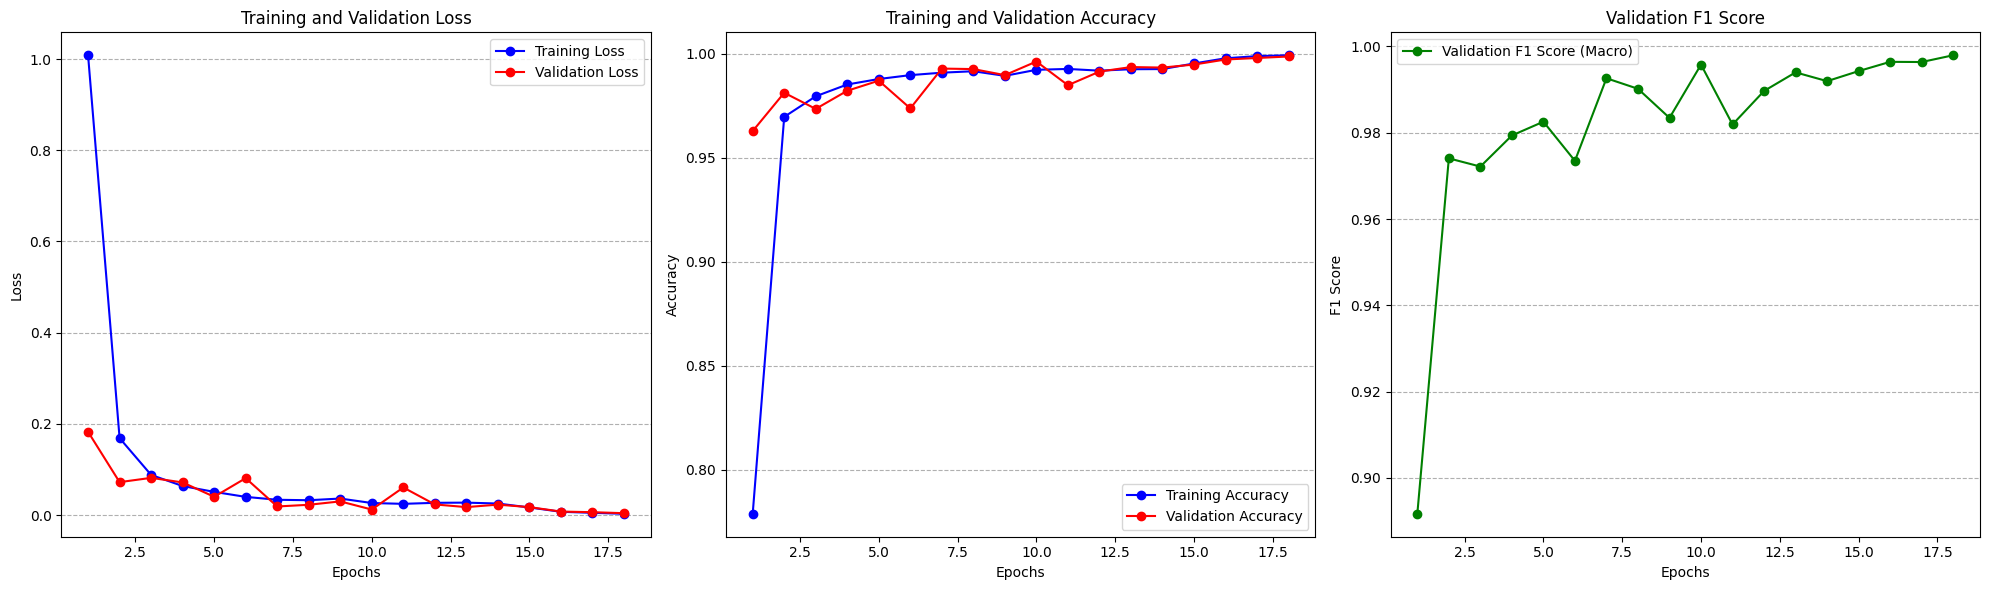

In [17]:
plot_history(history)



Evaluating best model on test set...


Validation:   0%|          | 0/65 [00:00<?, ?it/s]

<ipython-input-10-776727209af4>:18: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():


Val Loss: 0.0043 Acc: 0.9976 F1: 0.9976

--- Test Set Metrics (Best Model) ---
Accuracy: 0.9976
F1-Score (Macro): 0.9976
Precision (Macro): 0.9974
Recall (Macro): 0.9977
----------------------------------------

Classification Report (Test Set):
                                             precision    recall  f1-score   support

              Pepper__bell___Bacterial_spot     1.0000    1.0000    1.0000        98
                     Pepper__bell___healthy     1.0000    1.0000    1.0000       147
                      Potato___Early_blight     1.0000    1.0000    1.0000       101
                       Potato___Late_blight     1.0000    0.9892    0.9946        93
                           Potato___healthy     1.0000    1.0000    1.0000        16
                      Tomato_Bacterial_spot     1.0000    1.0000    1.0000       225
                        Tomato_Early_blight     0.9906    1.0000    0.9953       105
                         Tomato_Late_blight     0.9949    0.9949    0.994

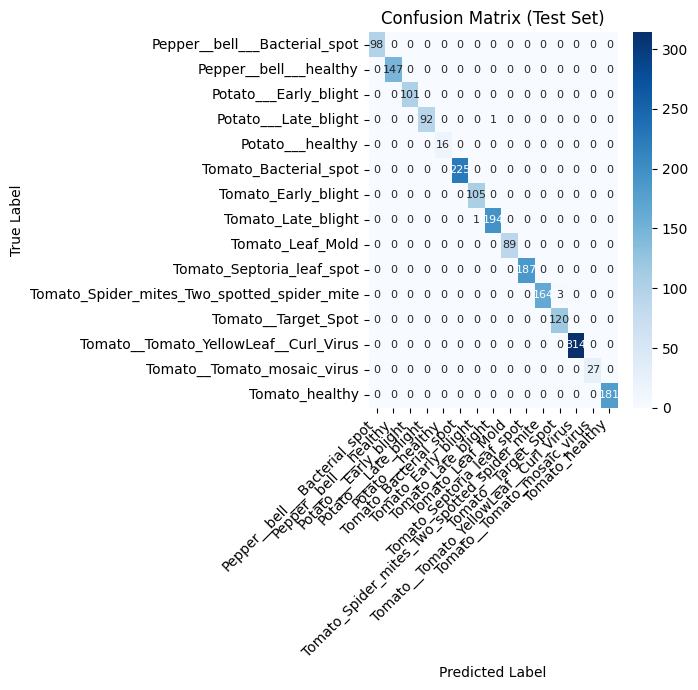

In [18]:
print("\nEvaluating best model on test set...")
test_loss, test_acc, test_f1, test_precision, test_recall, test_labels, test_preds = validate(
    ensemble_model, criterion, dataloaders['test'], device
)

print("\n--- Test Set Metrics (Best Model) ---")
print(f"Accuracy: {test_acc:.4f}")
print(f"F1-Score (Macro): {test_f1:.4f}")
print(f"Precision (Macro): {test_precision:.4f}")
print(f"Recall (Macro): {test_recall:.4f}")
print("-" * 40)

# Optionally: classification report and confusion matrix
print('\nClassification Report (Test Set):')
try:
    report = classification_report(test_labels, test_preds, target_names=class_names, digits=4, zero_division=0)
    print(report)
except ValueError as e:
    print(f"Could not generate report with class names: {e}")
    report = classification_report(test_labels, test_preds, digits=4, zero_division=0)
    print(report)

print('\nConfusion Matrix (Test Set):')
cm = confusion_matrix(test_labels, test_preds)
plt.figure(figsize=(7, 7))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names, annot_kws={"size": 8})
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix (Test Set)')
plt.xticks(rotation=45, ha='right')
plt.yticks(rotation=0)
plt.tight_layout()
plt.savefig("Confusion_matrix_test_ensemble.png", dpi = 300)
plt.show()


In [22]:
# ------------------------ SETUP ------------------------

import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import roc_curve, auc, confusion_matrix, classification_report
from torchsummary import summary
import pandas as pd
import numpy as np
import torch
import os

# Create directory to save plots
os.makedirs("plots", exist_ok=True)

# Ensure evaluation mode
ensemble_model.eval()

# ------------------------ EVALUATE MODEL & EXTRACT y_true, y_pred, y_prob ------------------------

all_labels = []
all_preds = []
all_probs = []

with torch.no_grad():
    for inputs, labels in valid_loader:  # ✅ corrected (valid_loader, not test_loader)
        inputs = inputs.to(device)
        labels = labels.to(device)

        outputs = ensemble_model(inputs)  # ✅ corrected (ensemble_model, not model)

        probs = torch.softmax(outputs, dim=1)
        _, preds = torch.max(outputs, 1)

        all_labels.extend(labels.cpu().numpy())
        all_preds.extend(preds.cpu().numpy())
        all_probs.extend(probs.cpu().numpy())

y_true = np.array(all_labels)
y_pred = np.array(all_preds)
y_prob = np.array(all_probs)

print(f"✅ Evaluation Done: {len(y_true)} samples.")

# ------------------------ TRACK TRAINING HISTORY ------------------------

# Assuming you tracked train_losses, val_losses, train_accuracies, val_accuracies
loss_hist = train_losses if 'train_losses' in globals() else []
acc_hist = train_accuracies if 'train_accuracies' in globals() else []

print(f"✅ Training History Extracted: {len(loss_hist)} epochs.")

# ------------------------ BEGIN PLOTTING ------------------------

# 1. Per-Class Metrics
report = classification_report(y_true, y_pred, output_dict=True, zero_division=0)
classes = list(report.keys())[:-3]
precision = [report[cls]["precision"] for cls in classes]
recall = [report[cls]["recall"] for cls in classes]
f1 = [report[cls]["f1-score"] for cls in classes]

fig, ax = plt.subplots(figsize=(12, 6))
x = np.arange(len(classes))
width = 0.25
ax.bar(x - width, precision, width, label='Precision')
ax.bar(x, recall, width, label='Recall')
ax.bar(x + width, f1, width, label='F1-Score')
ax.set_xlabel('Classes')
ax.set_ylabel('Scores')
ax.set_title('Per-Class Metrics')
ax.set_xticks(x)
ax.set_xticklabels(classes, rotation=90)
ax.legend()
plt.tight_layout()
plt.savefig("plots/per_class_metrics.png", dpi=300)
plt.show()

# 2. ROC Curves
fig, ax = plt.subplots(figsize=(10, 8))
for i in range(config["num_classes"]):
    fpr, tpr, _ = roc_curve((y_true == i).astype(int), y_prob[:, i])
    roc_auc = auc(fpr, tpr)
    ax.plot(fpr, tpr, label=f'Class {i} (AUC = {roc_auc:.2f})')

ax.plot([0, 1], [0, 1], 'k--')
ax.set_xlim([0.0, 1.0])
ax.set_ylim([0.0, 1.05])
ax.set_xlabel('False Positive Rate')
ax.set_ylabel('True Positive Rate')
ax.set_title('ROC Curves - One vs Rest')
ax.legend(loc="lower right")
plt.tight_layout()
plt.savefig("plots/roc_curves.png", dpi=300)
plt.show()

# 3. Training History
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 6))
ax1.plot(loss_hist, label='Train Loss', color='red')
ax1.set_title('Training Loss')
ax1.set_xlabel('Epoch')
ax1.set_ylabel('Loss')
ax1.legend()

ax2.plot(acc_hist, label='Train Accuracy', color='green')
ax2.set_title('Training Accuracy')
ax2.set_xlabel('Epoch')
ax2.set_ylabel('Accuracy')
ax2.legend()

plt.tight_layout()
plt.savefig("plots/training_history.png", dpi=300)
plt.show()

# 4. Performance Metrics Heatmap
metrics_df = pd.DataFrame(report).transpose()
fig, ax = plt.subplots(figsize=(12, 8))
sns.heatmap(metrics_df.iloc[:-3, :-1], annot=True, cmap="YlGnBu", fmt=".2f")
ax.set_title('Performance Metrics Heatmap')
plt.tight_layout()
plt.savefig("plots/performance_metrics.png", dpi=300)
plt.show()

# 5. Model Architecture
# Input channels: 3 (RGB), Size: config["image_size"] x config["image_size"]
summary(ensemble_model, (3, config["image_size"], config["image_size"]))  # ✅ correct model

# 6. Data Distribution
# Assuming train_dataset exists and is a torchvision dataset
class_indices = [label for _, label in train_dataset]
class_counts = pd.Series(class_indices).value_counts().sort_index()

fig, ax = plt.subplots(figsize=(12, 6))
sns.barplot(x=class_counts.index, y=class_counts.values, palette='viridis')
ax.set_xlabel('Classes')
ax.set_ylabel('Number of Samples')
ax.set_title('Data Distribution in Training Set')
plt.tight_layout()
plt.savefig("plots/data_distribution.png", dpi=300)
plt.show()

# 7. Confusion Matrix
cm = confusion_matrix(y_true, y_pred)
fig, ax = plt.subplots(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=classes, yticklabels=classes)
ax.set_xlabel('Predicted Labels')
ax.set_ylabel('True Labels')
ax.set_title('Confusion Matrix')
plt.tight_layout()
plt.savefig("plots/confusion_matrix.png", dpi=300)
plt.show()


NameError: name 'valid_loader' is not defined